# Fit to epidemiological models

## March 2020

In [1]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Apr  2 13:03:42 2020


In [2]:
import numpy as np
import pandas as pd
import matplotlib

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [4]:
## mathplotlib configuration
fontsize = 12
plt.rcParams["figure.figsize"] = 6, 5
plt.rcParams["font.size"     ] = fontsize

#font = {'family': 'serif',
#        'color':  'black',
#        'weight': 'bold',
#        'size': fontsize,
#        }

plt.style.context('seaborn-colorblind');


In [5]:
import scipy.stats  as stats

from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d

from dataclasses import dataclass, field

In [6]:
from   c19.types import SIR
import c19.basic_models as cbm
import c19.basic_models as sir_deriv

import c19.plotting as cplt
import c19.core_functions as cf

In [7]:
import c19.cfit         as cfit
import c19.myhistograms as mhst

In [8]:
import c19.cfitsir      as cfsir

# The SIR model

- A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

- $S(t)$ are those susceptible but not yet infected with the disease;
- $I(t)$ is the number of infectious individuals;
- $R(t)$ are those individuals who have recovered from the disease and now have immunity to it.

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 
β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ
is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$$
\frac{dS}{dt} = - \frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma R
$$

## Example

1. Define the SIR parameters.The model is initialised with the size of the population (N) and the initial values of the population. Here we choose I=1 (the epidemics starts with one infected case), R = 0 (no one has recovered yet), and S = N - I - R

2. The COVID parameters are: R0 =3, T = 7 days (T is the recovery/infection time). The parameters that enter the differential equations are gamma = 1/T and beta = R0 * gamma.

3. The system is solved for a time grid. 

### Initial conditions

In [9]:
N0     = cfsir.N0
R0     = cfsir.R0
gamma0 = cfsir.gamma0
beta0  = cfsir.beta0
alpha0 = beta0 - gamma0

### check SIR model

In [59]:
# Generate SIR model
isir = cfsir.sir(N0, beta0, gamma0)

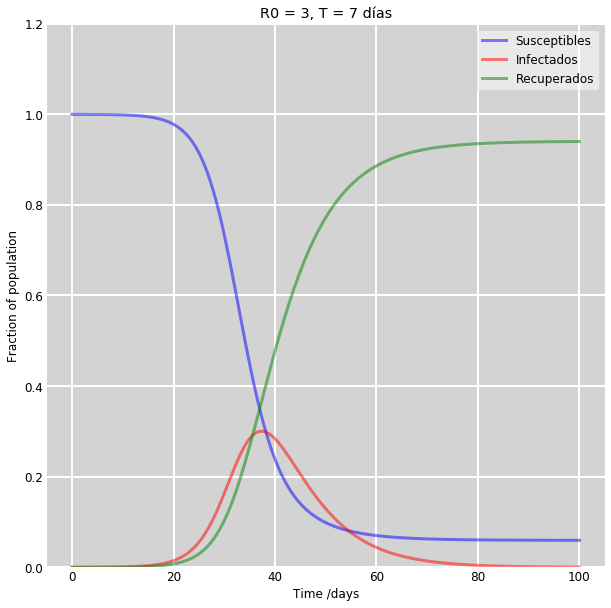

In [60]:
cplt.plot_sir(isir, "R0 = 3, T = 7 días")

### Generate Sir Experiment

In [100]:
cis, crs, ts = cfsir.sir_experiment(isir)
#ts = (tbins[1:] + tbins[:-1])/2.

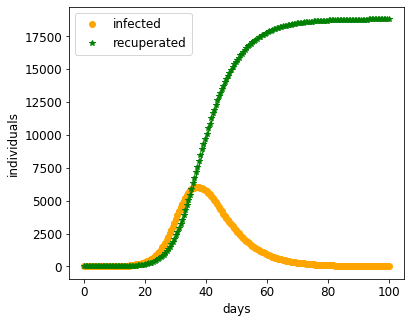

In [101]:
#ts = (tbins[1:] + tbins[:-1])/2.
plt.plot(ts, cis, marker = 'o', ls = '', color = 'orange', label = 'infected');
plt.plot(isir.t, isir.I, color = 'orange');
plt.plot(ts, crs, marker = '*', ls = '', color = 'green', label = 'recuperated')
plt.plot(isir.t, isir.R, color = 'green');
plt.xlabel('days'); plt.ylabel('individuals')
plt.legend();

### Kalman Filter

In [102]:
xs, uxs, ms, dms, ums, hs, res = cfsir.sir_kfilter(cis, crs, ts, N = N0, beta = 1, gamma = 1., full_output = True)

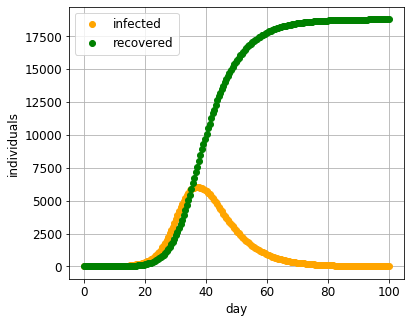

In [103]:
# Plot the infected and recovered cases vs day
_cis = [mi[0] for mi in ms]
_crs = [mi[1] for mi in ms] 
plt.plot(ts, _cis, marker = 'o', ls = '', color = 'orange', label = 'infected'); 
plt.plot(ts, _crs, marker = 'o', ls = '', color = 'green' , label = 'recovered'); 
plt.legend(); plt.xlabel('day'); plt.ylabel('individuals'); plt.grid();

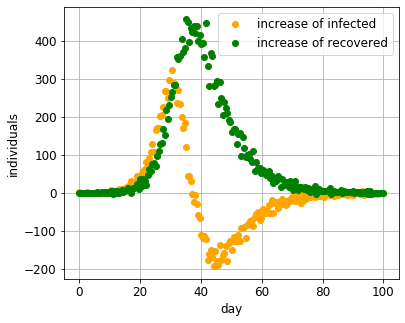

In [104]:
# Plot the increase of infected and recoved individuals per day per day
_cis = [mi[0] for mi in dms]
_crs = [mi[1] for mi in dms] 
plt.plot(ts, _cis, marker = 'o', ls = '', color = 'orange', label = r'increase of infected'); 
plt.plot(ts, _crs, marker = 'o', ls = '', color = 'green' , label = r'increase of recovered'); 
plt.legend(); plt.xlabel('day'); plt.ylabel('individuals'); plt.grid();

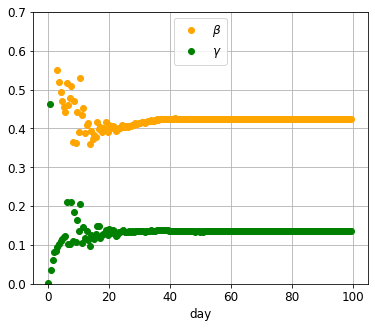

In [105]:
## plot results
betas  = [xi[0] for xi in xs]
gammas = [xi[1] for xi in xs] 
plt.plot(ts, betas, marker = 'o', ls = '', color = 'orange', label = r'$\beta$'); 
plt.plot(ts, gammas, marker = 'o', ls = '', color = 'green' , label = r'$\gamma$'); 
plt.legend(); plt.xlabel('day'); plt.grid(); plt.ylim((0., 0.7));

True parameters 0.42857142857142855 0.14285714285714285


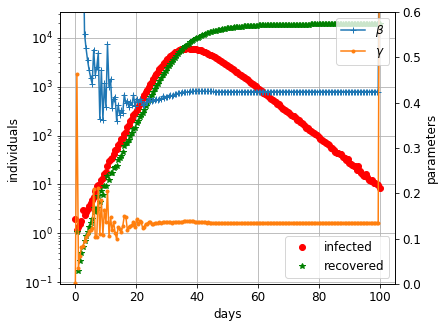

In [111]:
### Pretty plot
mis = [mi[0] for mi in ms]
mrs = [mi[1] for mi in ms]
plt.plot(isir.t, mis, marker = 'o', ls ='', color = 'red', label = 'infected');
plt.plot(isir.t, mrs, marker = '*', ls ='', color = 'green' , label = 'recovered');
plt.legend(); plt.grid(True); plt.yscale('log')
plt.xlabel('days'); plt.ylabel('individuals')

betas  = [xi[0] for xi in xs]
gammas = [xi[1] for xi in xs] 
ax  = plt.gca()
ax2 = ax.twinx()
ax2.plot(isir.t, betas , marker = '+', label = r'$\beta$');
ax2.plot(isir.t, gammas, marker = '.', label = r'$\gamma$');
ax2.set_ylim((0., 0.6));
plt.legend(loc = 1); ax2.set_ylabel('parameters');
print('True parameters', beta0, gamma0)

In [ ]:
###---- Here we are